COVID-19 Modelling Final Project 

In [ ]:
# imports
import pandas as pd
import numpy as np
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from google.colab import files

# show plots inline for notebooks


# Introduction</br>

In this project we'll explore the Covid-19 outbreak in the province of Ontario. We will specifically focus on: </br>


*   Exploring data related to the spread of Covid-19 in Ontario and draw insights from the data. 
*   Building an **S**usceptible **I**nfected **R**emoved (**SIR**) model to gain insights on current state of the pandemic as well as for porjecting the spread into the future.
*   Model the impact of vaccinations in controlling the spread of the disease. Recent polls have found that close to 30% of Canadians are reluctant to get vacciniated. We believe that a model that clearly shows the benefits of mass inocculation can be a useful policy tool for generating awareness and increasing the uptake of the vaccine.



#Part 1 - Data Cleaning</br>

Load data about Covid-19 from the CSSEGIS Data set. </br>

**Note:** The John Hopkins dataset does not contain data for recoveries in Ontario (it only has Canada). We will hence use the recoveries data from the province's website (https://data.ontario.ca/dataset/status-of-covid-19-cases-in-ontario/resource/ed270bb8-340b-41f9-a7c6-e8ef587e6d11). 

In [397]:
# John Hopkins Data set
rawJH = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
rawJH_died = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
rawOntario = rawJH[rawJH['Province/State']=='Ontario']
rawOntario_died = rawJH_died[rawJH_died['Province/State']=='Ontario']
rawOntario = rawOntario.iloc[:,0:328]
rawOntario_died = rawOntario_died.iloc[:,0:328]

print(rawOntario.head())
print(rawOntario_died.head())


   Province/State Country/Region      Lat  ...  12/8/20  12/9/20  12/10/20
49        Ontario         Canada  51.2538  ...   134605   136599    138529

[1 rows x 328 columns]
   Province/State Country/Region      Lat  ...  12/8/20  12/9/20  12/10/20
49        Ontario         Canada  51.2538  ...     3827     3861      3891

[1 rows x 328 columns]


In [ ]:
uploader=files.upload()

Saving covidtesting.csv to covidtesting.csv


In [398]:
# Governemnt of Ontario Dataset
ontario_gov_data = pd.read_csv('covidtesting.csv')
ontario_gov_data = ontario_gov_data.fillna(0)
ontario_gov_data

,Reported Date,Confirmed Negative,Presumptive Negative,Presumptive Positive,Confirmed Positive,Resolved,Deaths,Total Cases,Total patients approved for testing as of Reporting Date,Total tests completed in the last day,Percent positive tests in last day,Under Investigation,Number of patients hospitalized with COVID-19,Number of patients in ICU with COVID-19,Number of patients in ICU on a ventilator with COVID-19,Total Positive LTC Resident Cases,Total Positive LTC HCW Cases,Total LTC Resident Deaths,Total LTC HCW Deaths
0,2020-01-26,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-27,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-28,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-30,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,2020-12-06,0.0,0.0,0.0,15547.0,107990.0,3772.0,127309.0,6581306.0,59251.0,3.9,47850.0,701.0,204.0,109.0,8895.0,3487.0,2378.0,8.0
316,2020-12-07,0.0,0.0,0.0,16034.0,109402.0,3798.0,129234.0,6626589.0,45283.0,4.0,31238.0,725.0,213.0,121.0,8966.0,3504.0,2391.0,8.0
317,2020-12-08,0.0,0.0,0.0,16151.0,110951.0,3808.0,130910.0,6665787.0,39198.0,5.0,40732.0,794.0,219.0,132.0,9004.0,3522.0,2396.0,8.0
318,2020-12-09,0.0,0.0,0.0,16089.0,112875.0,3836.0,132800.0,6714333.0,48546.0,4.4,54613.0,811.0,221.0,129.0,9045.0,3549.0,2407.0,8.0


We'll next extract daily case counts from cumalative case counts. 

In [399]:
# Drop unwanted columns
ontario_cases = rawOntario.drop(['Province/State','Country/Region','Lat','Long'],axis = 1).transpose()
ontario_cases=ontario_cases.rename(columns={49:"cummulative"})

# Extract daily cases from cummulative cases
ontario_cases['daily'] = ontario_cases['cummulative'].diff().fillna(ontario_cases['cummulative'])

ontario_cases=ontario_cases.drop(['1/22/20','1/23/20','1/24/20','1/25/20'],axis=0) # dropped first 4 days as they are missing from the ontario dataset
#ontario_gov_data=ontario_gov_data.drop(319,axis=0)

#Merge recoveries and deaths into ontario_cases
interim2 = rawOntario_died.drop(['Province/State','Country/Region','Lat','Long'],axis = 1).transpose()
interim2=interim2.rename(columns={49:"Deaths"})

ontario_cases['Resolved']=list(ontario_gov_data['Resolved'])
ontario_cases['Deaths']=interim2['Deaths']

ontario_cases=ontario_cases.fillna(0) # The only missing data is in the beginning when reporting had not yet started for resolved cases

#Generate dates in Month-Date format
dates = []
for date in ontario_cases.index:
  interim = dt.datetime.strptime(date,"%m/%d/%y")
  dates.append(interim.strftime("%b-%d"))



Consolidated data from the two sources into one dataframe containing:

*   Cummulative cases
*   Daily cases
* Cummulative resolved
* Cummulative deaths






In [400]:
ontario_cases

,cummulative,daily,Resolved,Deaths
1/26/20,1,1.0,0.0,0
1/27/20,1,0.0,0.0,0
1/28/20,1,0.0,0.0,0
1/29/20,1,0.0,0.0,0
1/30/20,1,0.0,0.0,0
...,...,...,...,...
12/6/20,130962,1965.0,107990.0,3794
12/7/20,132736,1774.0,109402.0,3816
12/8/20,134605,1869.0,110951.0,3827
12/9/20,136599,1994.0,112875.0,3861


As we are building an SIR model, we'll need to account for the total 'Removed' population which is Recoveries + Deaths.</br>

We'll also need the number of active cases on each day as these are the number of 'Infected' cases in the SIR model 

In [401]:
ontario_cases['Removed'] = ontario_cases['Deaths']+ontario_cases['Resolved']
ontario_cases['Active'] = ontario_cases['cummulative']-ontario_cases['Removed']

# Part 2 - Data Exploration

Let's plot some curves to visualise the progression of the pandemic.</br>

We will also plot major events such as lockdowns, reopenings, mandatory mask wearing etc.The dates are obtained from the following source:  
https://globalnews.ca/news/6859636/ontario-coronavirus-timeline/

##Daily Case Counts

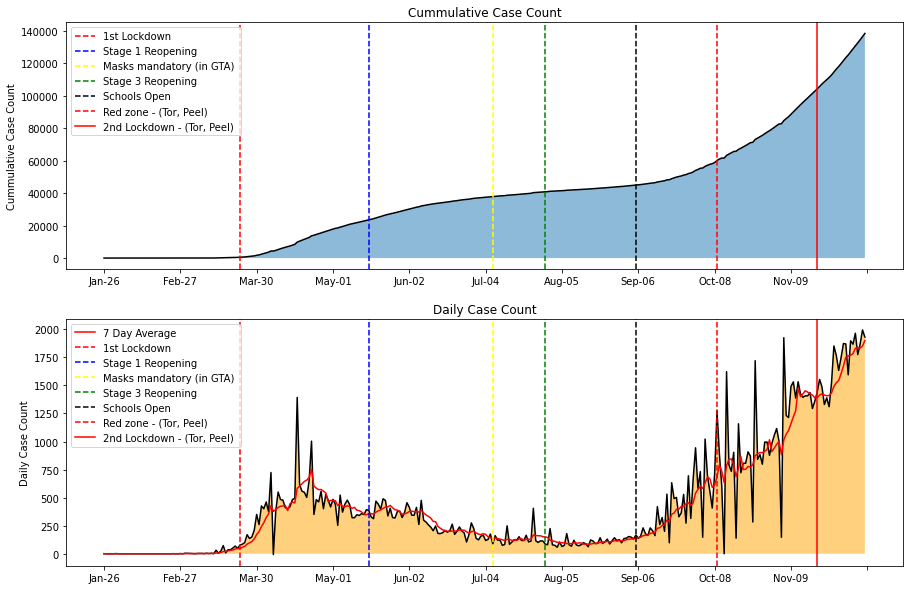

In [402]:
fig,ax = plt.subplots(2,figsize=(15,10))

ax[0].plot(dates,ontario_cases['cummulative'],color = 'black')
ax[0].axvline(x='Mar-23',label='1st Lockdown',linestyle = '--',color='red')
ax[0].axvline(x='May-16',label='Stage 1 Reopening',linestyle = '--',color='blue')
ax[0].axvline(x='Jul-07',label='Masks mandatory (in GTA) ',linestyle = '--',color='yellow')
ax[0].axvline(x='Jul-29',label='Stage 3 Reopening',linestyle = '--',color='green')
ax[0].axvline(x='Sep-05',label='Schools Open',linestyle = '--',color='black')
ax[0].axvline(x='Oct-09',label='Red zone - (Tor, Peel)',linestyle = '--',color='red')
ax[0].axvline(x='Nov-20',label='2nd Lockdown - (Tor, Peel)',linestyle = '-',color='red')
ax[0].set_ylabel('Cummulative Case Count')
ax[0].set_title('Cummulative Case Count')
ax[0].fill_between(dates,ontario_cases['cummulative'].values,alpha=0.5)
ax[0].legend()

ax[1].plot(dates,ontario_cases['daily'],color = 'black')
ax[1].plot(dates,ontario_cases['daily'].rolling(7).mean().fillna(0),color='red',label = '7 Day Average')
ax[1].axvline(x='Mar-23',label='1st Lockdown',linestyle = '--',color='red')
ax[1].axvline(x='May-16',label='Stage 1 Reopening',linestyle = '--',color='blue')
ax[1].axvline(x='Jul-07',label='Masks mandatory (in GTA) ',linestyle = '--',color='yellow')
ax[1].axvline(x='Jul-29',label='Stage 3 Reopening',linestyle = '--',color='green')
ax[1].axvline(x='Sep-05',label='Schools Open',linestyle = '--',color='black')
ax[1].axvline(x='Oct-09',label='Red zone - (Tor, Peel)',linestyle = '--',color='red')
ax[1].axvline(x='Nov-20',label='2nd Lockdown - (Tor, Peel)',linestyle = '-',color='red')
ax[1].set_ylabel('Daily Case Count')
ax[1].set_title('Daily Case Count')
ax[1].fill_between(dates,ontario_cases['daily'].values,alpha=0.5,facecolor='orange')
ax[1].legend()

plt.setp(ax,xticks = [i for i in range(0,324,32)])
plt.show()

## Active and Removed Cases

As we are trying to build an **SIR** modle, we'll need curves for number of active and number of removed cases. We'll plot these curves here.

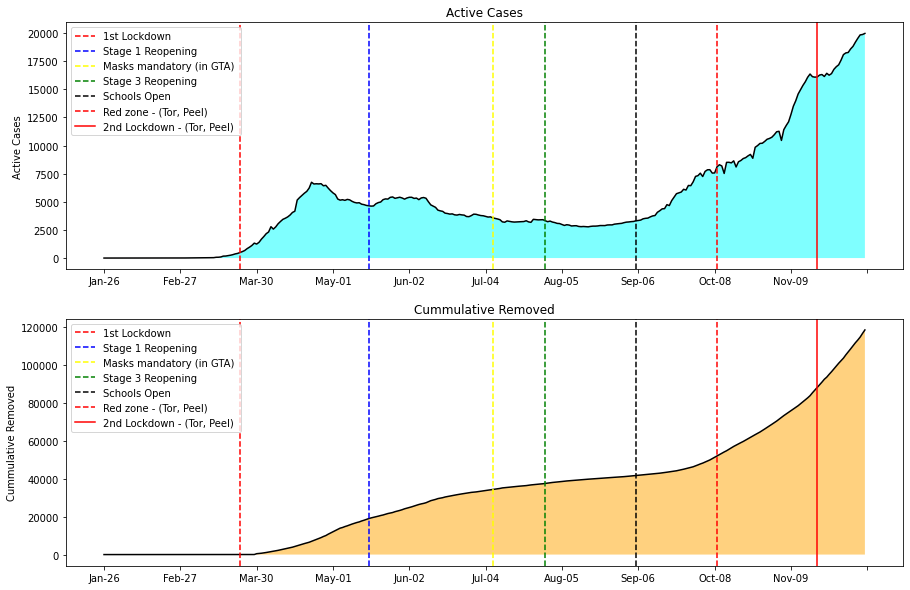

In [403]:
fig,ax = plt.subplots(2,figsize=(15,10))

ax[0].plot(dates,ontario_cases['Active'],color = 'black')
ax[0].axvline(x='Mar-23',label='1st Lockdown',linestyle = '--',color='red')
ax[0].axvline(x='May-16',label='Stage 1 Reopening',linestyle = '--',color='blue')
ax[0].axvline(x='Jul-07',label='Masks mandatory (in GTA) ',linestyle = '--',color='yellow')
ax[0].axvline(x='Jul-29',label='Stage 3 Reopening',linestyle = '--',color='green')
ax[0].axvline(x='Sep-05',label='Schools Open',linestyle = '--',color='black')
ax[0].axvline(x='Oct-09',label='Red zone - (Tor, Peel)',linestyle = '--',color='red')
ax[0].axvline(x='Nov-20',label='2nd Lockdown - (Tor, Peel)',linestyle = '-',color='red')
ax[0].set_ylabel('Active Cases')
ax[0].set_title('Active Cases')
ax[0].fill_between(dates,ontario_cases['Active'].values,alpha=0.5,facecolor = 'cyan')
ax[0].legend()
ax[1].plot(dates,ontario_cases['Removed'],color = 'black')
ax[1].axvline(x='Mar-23',label='1st Lockdown',linestyle = '--',color='red')
ax[1].axvline(x='May-16',label='Stage 1 Reopening',linestyle = '--',color='blue')
ax[1].axvline(x='Jul-07',label='Masks mandatory (in GTA) ',linestyle = '--',color='yellow')
ax[1].axvline(x='Jul-29',label='Stage 3 Reopening',linestyle = '--',color='green')
ax[1].axvline(x='Sep-05',label='Schools Open',linestyle = '--',color='black')
ax[1].axvline(x='Oct-09',label='Red zone - (Tor, Peel)',linestyle = '--',color='red')
ax[1].axvline(x='Nov-20',label='2nd Lockdown - (Tor, Peel)',linestyle = '-',color='red')
ax[1].set_ylabel('Cummulative Removed')
ax[1].set_title('Cummulative Removed')
ax[1].legend()
ax[1].fill_between(dates,ontario_cases['Removed'].values,alpha=0.5,facecolor='orange')

plt.setp(ax,xticks = [i for i in range(0,324,32)])
plt.show()

From the above curves, we can clearly see the 2 waves of the pandemic. </br>
The first wave is charecterised by the steep rise in infecitons in early march, followed by a peak in late April and a subsequent decline till early august.</br>

We are currently in the 2nd wave which began in early September marked by a gradual increase in the number of active infections. </br>



## Cummulative Deaths and Recoveries

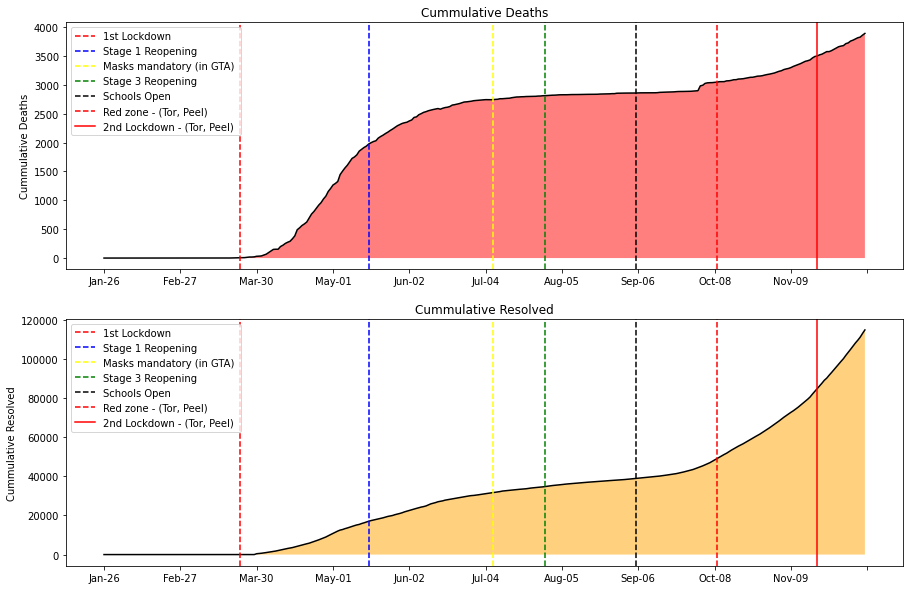

In [404]:
fig,ax = plt.subplots(2,figsize=(15,10))

ax[0].plot(dates,ontario_cases['Deaths'],color = 'black')
ax[0].axvline(x='Mar-23',label='1st Lockdown',linestyle = '--',color='red')
ax[0].axvline(x='May-16',label='Stage 1 Reopening',linestyle = '--',color='blue')
ax[0].axvline(x='Jul-07',label='Masks mandatory (in GTA) ',linestyle = '--',color='yellow')
ax[0].axvline(x='Jul-29',label='Stage 3 Reopening',linestyle = '--',color='green')
ax[0].axvline(x='Sep-05',label='Schools Open',linestyle = '--',color='black')
ax[0].axvline(x='Oct-09',label='Red zone - (Tor, Peel)',linestyle = '--',color='red')
ax[0].axvline(x='Nov-20',label='2nd Lockdown - (Tor, Peel)',linestyle = '-',color='red')
ax[0].set_ylabel('Cummulative Deaths')
ax[0].set_title('Cummulative Deaths')
ax[0].fill_between(dates,ontario_cases['Deaths'].values,alpha=0.5,facecolor = 'red')
ax[0].legend()
ax[1].plot(dates,ontario_cases['Resolved'],color = 'black')
ax[1].axvline(x='Mar-23',label='1st Lockdown',linestyle = '--',color='red')
ax[1].axvline(x='May-16',label='Stage 1 Reopening',linestyle = '--',color='blue')
ax[1].axvline(x='Jul-07',label='Masks mandatory (in GTA) ',linestyle = '--',color='yellow')
ax[1].axvline(x='Jul-29',label='Stage 3 Reopening',linestyle = '--',color='green')
ax[1].axvline(x='Sep-05',label='Schools Open',linestyle = '--',color='black')
ax[1].axvline(x='Oct-09',label='Red zone - (Tor, Peel)',linestyle = '--',color='red')
ax[1].axvline(x='Nov-20',label='2nd Lockdown - (Tor, Peel)',linestyle = '-',color='red')
ax[1].set_ylabel('Cummulative Resolved')
ax[1].set_title('Cummulative Resolved')
ax[1].legend()
ax[1].fill_between(dates,ontario_cases['Resolved'].values,alpha=0.5,facecolor='orange')

plt.setp(ax,xticks = [i for i in range(0,324,32)])
plt.show()

# Part 3 - Covid 19 Modelling

We will adopt an SIR model for estimating the spread of COVID-19 in Ontario. Looking at the above plots, we can see that Ontario experienced the first wave of the pandemic in the spring and is currently going through a much bigger second wave. </br>

For the SIR modelling, we will start by modelling the first wave as we can see a clear peak in cases followed by a subsequent decline. This trend is similar to how the SIR model captures the change in infecitons and modelling the first wave on it's own reduces the modelling complexity and will also give us an insight into how well our predictions compare with actual data.  

##Model Implementation Details</br>

The **SIR** model is governed by the following Ordinary Differental Equation:</br>

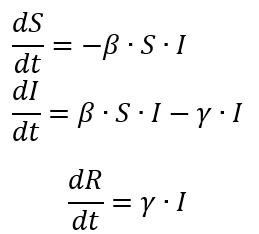


### Model Parameters

Here **beta** is the transmission rate and **gamma** is the recovery rate. The transmission rate for the disease will most likely decrease over time as more policies are put in place (lockdowns, social distancing, mask wearing etc.). </br>

This decrease in transmission rate is modelled by using a decaying exponential function:</br> 

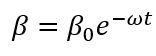


Here β_0 is the inital infection rate and ω is the exponential decay factor. These quantities are unknown and will be estimated from the curve fitting. This model for β is borrowed from [1].</br>



https://www.researchgate.net/publication/341169980_Describing_the_COVID-19_Outbreak_-_Fitting_Modified_SIR_models_to_Data

γ is the recovery rate and is the time it takes for the infected person to recover and to stop being contagious. Currently, the best estimate for the time for recovery is aorund 14 days (hence the province recommends a 14 day quarentine period after infection or possible exposure). We will therefore fix γ at **γ=1/14=0.07**.  

### Model Initial Conditions</br>

The Initial conditions for the first wave are estimated as:


*   I_0 (Initial number of infected people) : This parameter is difficult to estimate as the disease was brought to Ontario by people travelling to the province from outside destinations. Community spread of the disease only began after some number of infected people arrived from outside the borders. As it is difficult to estimate I_0, we will use it as a free variable in our curve fitting routine.      
*   S_0 (Number of susciptible people) = 15,000,000 - I_0. This is the estimated population of Ontario that would've been suscipitble at the beginning of the outbreak.
*   R_0 (Number of recovered) = 0.



##First Wave Modelling
We'll model the first wave as starting in january and ending in mid august when the number of active cases were at the lowest. </br>



In [405]:
first_wave=list(ontario_cases['Removed'].iloc[0:202])
first_wave_days = np.arange(0,202)
first_wave_dates = dates[0:202]

In [406]:
from scipy.integrate import odeint

In [407]:
# SIR model differetial equations
def SIR(t,b_0,omega,I0):
  N=15000000
  def dI(y,t,b_0,omega,N):
    S,I,R = y
    gamma = 0.07
    dSdt = -gamma*I*b_0*np.exp(-omega*t)*S/(N*gamma)
    dIdt = gamma*I*(b_0*np.exp(-omega*t)*S/(N*gamma)-1)
    dRdt = gamma*I
    return dSdt,dIdt,dRdt
  y0 = [N-I0,I0,0]
  sol = odeint(dI,y0,t,args=(b_0,omega,N))
  return sol[:,2]

The 'curve_fit' function fits the SIR model parameters (β_0,ω and I_0) to the cummulative recoveries data by minimzing the sum of squared errors between the data and the model predictions. This is done by performing a non-linear least square optimization. 

In [408]:
# Fitting SIR equation parameters to cummulative recoveries curve 
SIR_fit,SIR_cov = curve_fit(SIR,first_wave_days,first_wave,p0=[0.5,0.045,1],maxfev=5000)

/usr/local/lib/python3.6/dist-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [409]:
print('The predicted model prameters are:')
print('beta_0 = {}'.format(SIR_fit[0]))
print('omega = {}'.format(SIR_fit[1]))
print('I_0 = {}'.format(SIR_fit[2]))

The predicted model prameters are:
beta_0 = 0.3219475715439242
omega = 0.013972667216093172
I_0 = 0.20926502941441483


First wave fitted SIR model:

In [410]:
def dI(y,t,b_0,omega,gamma,N):
  S,I,R = y
  dSdt = -gamma*I*b_0*np.exp(-omega*t)*S/(N*gamma)
  dIdt = gamma*I*(b_0*np.exp(-omega*t)*S/(N*gamma)-1)
  dRdt = gamma*I
  return dSdt,dIdt,dRdt

In [411]:
N = 15000000
y0 = [N-SIR_fit[2],SIR_fit[2],0]
sol = odeint(dI,y0,first_wave_days,args=(SIR_fit[0],SIR_fit[1],0.07,N))
R_0 = SIR_fit[0]*np.exp(-SIR_fit[1]*first_wave_days)/0.07

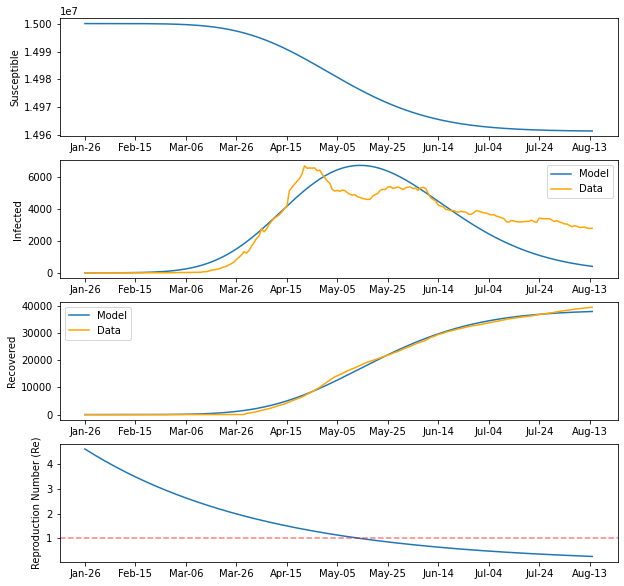

In [412]:
fig,ax = plt.subplots(4,figsize=(10,10))
ax[0].plot(first_wave_dates,sol[:,0],label='Model')
ax[0].set_ylabel('Susceptible')
ax[1].plot(first_wave_dates,sol[:,1],label='Model',color='C0')
ax[1].plot(first_wave_dates,ontario_cases['Active'].iloc[0:202],label='Data',color='orange')
ax[1].set_ylabel('Infected')
ax[1].legend()
ax[2].plot(first_wave_dates,sol[:,2],label = 'Model',color='C0')
ax[2].plot(first_wave_dates,ontario_cases['Removed'].iloc[0:202],label = 'Data',color = 'orange')
ax[2].set_ylabel('Recovered')
ax[2].legend()
ax[3].plot(first_wave_dates,R_0)
ax[3].axhline(y=1,linestyle='--',color = 'red',alpha = 0.5)
ax[3].set_ylabel('Reproduction Number (Re)')

plt.setp(ax,xticks = [i for i in range(0,202,20)])
plt.show()

The resultant model fits the data fairly well. The model predicts an almost symmetric rise and fall in number of infections. The actual rise behaves a bit differently with a quicker rise to the peak and gradual decline in cases. This leads to some discrepencies between the model and the data but the model is still able to capture the magnitude of the peak very accurately. </br>



Having modelled the first wave relatively accurately, we feel more confident about our model assumptions and can now proceed to model the current wave with the same assumptions.</br>

We'll also use the predicted S,I and R values for Aug-13th as our initial conditions for the second wave. 

##Second Wave Modelling 

We'll model our second wave as beginning in mig august and continiuing to date. We'll use data till december 10th to fit our model

In [413]:
second_wave=list(ontario_cases['Resolved'].iloc[202:])
second_wave_days = np.arange(0,118)
second_wave_dates = dates[202:]
predict_dates = second_wave_dates
for day in ['Dec-11','Dec-12','Dec-13','Dec-14','Dec-15','Dec-16','Dec-17','Dec-18','Dec-19','Dec-20','Dec-21','Dec-22','Dec-23','Dec-24','Dec-25','Dec-26','Dec-27','Dec-28','Dec-29','Dec-30','Dec-31','Jan-01','Jan-02','Jan-03','Jan-04','Jan-05','Jan-06','Jan-07','Jan-08','Jan-09','Jan-10','Jan-11']:
  predict_dates.append(day)
first_wave_I=sol[-1,1]
first_wave_S=sol[-1,0]
first_wave_R=sol[-1,2]
print('S_0 for second wave: {} '.format(first_wave_S))
print('I_0 for second wave: {} '.format(first_wave_I))
print('R_0 for second wave: {} '.format(first_wave_R))

S_0 for second wave: 14961578.401117764 
I_0 for second wave: 405.82490688346644 
R_0 for second wave: 38015.77397535857 


In [414]:
#2nd wave SIR fitting model (upto dec 10)
def SIR_2(t,b_0,omega,I0):
  N = 14961576
  def dI(y,t,b_0,omega):
    S,I,R = y
    gamma = 0.07
    dSdt = -gamma*I*b_0*np.exp(-omega*t)*S/(N*gamma)
    dIdt = gamma*I*(b_0*np.exp(-omega*t)*S/(N*gamma)-1)
    dRdt = gamma*I
    return dSdt,dIdt,dRdt
  y0 = [N-I0,I0,38016]
  sol = odeint(dI,y0,t,args=(b_0,omega))
  return sol[:,2]

In [415]:
#SIR Curve fit 
SIR_fit,SIR_cov = curve_fit(SIR_2,second_wave_days,second_wave,p0=[0.5,0.045,first_wave_I],maxfev=5000)


In [416]:
# Fitted model (upto dec 10)
def dIs(y,t,b_0,omega):
  S,I,R = y
  gamma = 0.07
  dSdt = -gamma*I*b_0*np.exp(-omega*t)*S/(N*gamma)
  dIdt = gamma*I*(b_0*np.exp(-omega*t)*S/(N*gamma)-1)
  dRdt = gamma*I
  return dSdt,dIdt,dRdt

In [417]:
fit_days = np.linspace(0,118,118)
N = 15000000
y0 = [N-SIR_fit[2],SIR_fit[2],38000]
sol = odeint(dIs,y0,fit_days,args=(SIR_fit[0],SIR_fit[1]))
R_0 = SIR_fit[0]*np.exp(-SIR_fit[1]*fit_days)/0.07 

###Base Case Scenario </br>
For the base case scenario, we'll assume the transmission rate (β) to be fixed for the next 30 days. This is as opposed to an exponentially decaying model we've used so far.

In [418]:
# SIR mopdel with constant transmission rate
def dIs_base(y,t,b):
  S,I,R = y
  gamma = 0.07
  dSdt = -gamma*I*b*S/(N*gamma)
  dIdt = gamma*I*(b*S/(N*gamma)-1)
  dRdt = gamma*I
  return dSdt,dIdt,dRdt

In [419]:
predict_days = np.linspace(118,150,32)
R_0_base = np.zeros(32)
N = 15000000
y0 = [sol[-1,0],sol[-1,1],sol[-1,2]]
b = SIR_fit[0]*np.exp(-SIR_fit[1]*118)
sol_base = odeint(dIs_base,y0,predict_days,args=(b,))
R_0_base[:] = R_0[-1] 

###Best Case Scenario

For the best case scenario, we'll assume the transmission rate continiues on the same exponentially decaying downward trajectory predicted so far

In [420]:
fit_best_days = np.linspace(0,150,150)
N = 15000000
y0 = [N-SIR_fit[2],SIR_fit[2],38000]
sol_b = odeint(dIs,y0,fit_best_days,args=(SIR_fit[0],SIR_fit[1]))
R_0_b = SIR_fit[0]*np.exp(-SIR_fit[1]*fit_best_days)/0.07 
sol_best = sol_b[118:,:]
R_0_best = R_0_b[118:]

###Worst Case Scenario</br>

For the worst case scenario, we'll assume the transmission rate stays at a 20% elevated rate for the next 30 days (compared to the R_0 on dec 10).  

In [421]:
predict_days = np.linspace(118,150,32)
R_0_worst = np.zeros(32)
N = 15000000
y0 = [sol[-1,0],sol[-1,1],sol[-1,2]]
b = SIR_fit[0]*np.exp(-SIR_fit[1]*118)*1.2
sol_worst = odeint(dIs_base,y0,predict_days,args=(b,))
R_0_worst[:] = b/0.07 

## Projection Plots

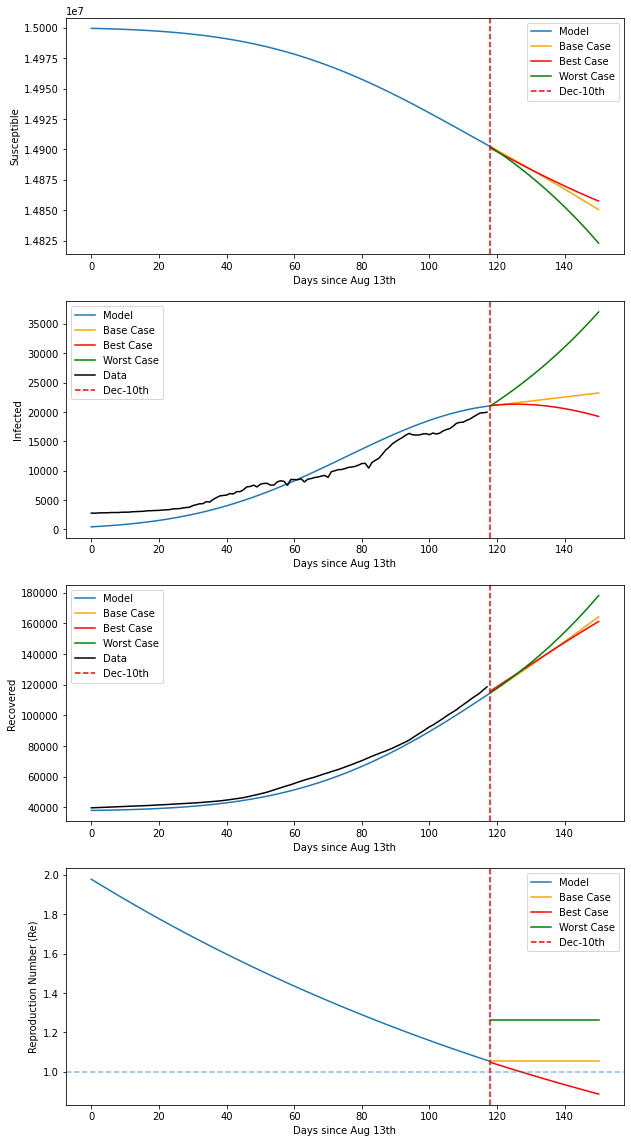

In [422]:
fig,ax = plt.subplots(4,figsize=(10,20))
ax[0].plot(fit_days,sol[:,0],label='Model',c='C0')
ax[0].plot(predict_days,sol_base[:,0],label='Base Case',c='orange')
ax[0].plot(predict_days,sol_best[:,0],label='Best Case',c='red')
ax[0].plot(predict_days,sol_worst[:,0],label='Worst Case',c='green')
ax[0].axvline(x=118,color='r',linestyle = '--',label = 'Dec-10th')
ax[0].set_ylabel('Susceptible')
ax[0].set_xlabel('Days since Aug 13th')
ax[0].legend()

ax[1].plot(fit_days,sol[:,1],label='Model',c='C0')
ax[1].plot(predict_days,sol_base[:,1],label='Base Case',c='orange')
ax[1].plot(predict_days,sol_best[:,1],label='Best Case',c='red')
ax[1].plot(predict_days,sol_worst[:,1],label='Worst Case',c='green')
ax[1].plot(second_wave_days,ontario_cases['Active'].iloc[202:],label='Data',c='black')
ax[1].axvline(x=118,color='r',linestyle = '--',label = 'Dec-10th')
ax[1].set_ylabel('Infected')
ax[1].set_xlabel('Days since Aug 13th')
ax[1].legend()

ax[2].plot(fit_days,sol[:,2],label='Model',c='C0')
ax[2].plot(predict_days,sol_base[:,2],label='Base Case',c='orange')
ax[2].plot(predict_days,sol_best[:,2],label='Best Case',c='red')
ax[2].plot(predict_days,sol_worst[:,2],label='Worst Case',c='green')
ax[2].plot(second_wave_days,ontario_cases['Removed'].iloc[202:],label='Data',c='black')
ax[2].axvline(x=118,color='r',linestyle = '--',label = 'Dec-10th')
ax[2].set_ylabel('Recovered')
ax[2].set_xlabel('Days since Aug 13th')
ax[2].legend()

ax[3].plot(fit_days,R_0,label='Model',c='C0')
ax[3].plot(predict_days,R_0_base,label='Base Case',c='orange')
ax[3].plot(predict_days,R_0_best,label='Best Case',c='red')
ax[3].plot(predict_days,R_0_worst,label='Worst Case',c='green')
ax[3].axvline(x=118,color='r',linestyle = '--',label = 'Dec-10th')
ax[3].axhline(y=1,linestyle='--',alpha=0.5)
ax[3].set_ylabel('Reproduction Number (Re)')
ax[3].set_xlabel('Days since Aug 13th')
ax[3].legend()

#plt.setp(ax,xticks = [i for i in range(0,150,15)])
plt.show()

We'll evaluate our assumptions about the transmission rate decay function by comparing the predicted R_0 by the R_0 published by the Ontario government. (The report can be found here: https://www.publichealthontario.ca/-/media/documents/ncov/epi/covid-19-epi-trends-incidence-ontario.pdf?la=en)

**Ontario Epidemiology model R_0:**

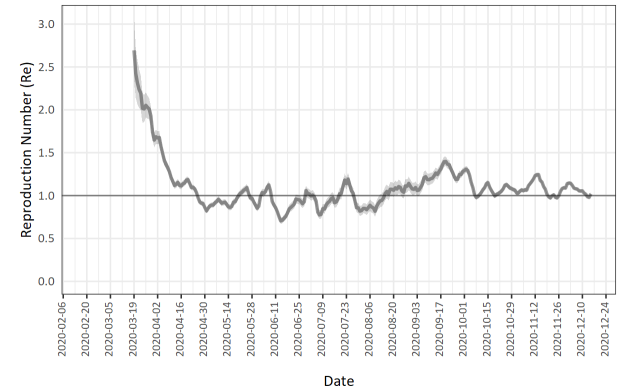

**First wave predicted R_0:**

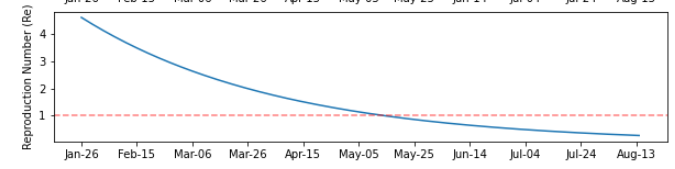

**2nd wave predicted R_0:**

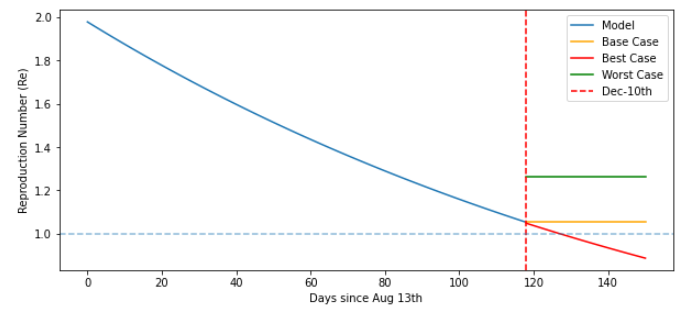

The exponential decay function seems to be a reasonable choice for modelling the first wave. We see a high R_0 initially (predicted = 3.0, actual = 2.7 in March) which rapidly decays to below 1 (<1 in mid may- predicted, <1 in late april-actual)    </br>

The exponential decay is however not applicable to subsequent progressions as the R_0 now oscillates around 1, charecterised by periods of increased transmission followed by relaxation. The accuracy of our prediction can probably be improved by using a similar oscillating function (perhaps a decaying sin function).   

Changing the R_0 value seems to be a reasonable way of predicting the best,worst and base case scenarios as large uncertainties are associated with predicting R_0. Covering a range of possible R_0 values, hence seems to be a reasonable modelling approach.</br>
This method is also backed up by the models published by Ontario Health as shown below:  

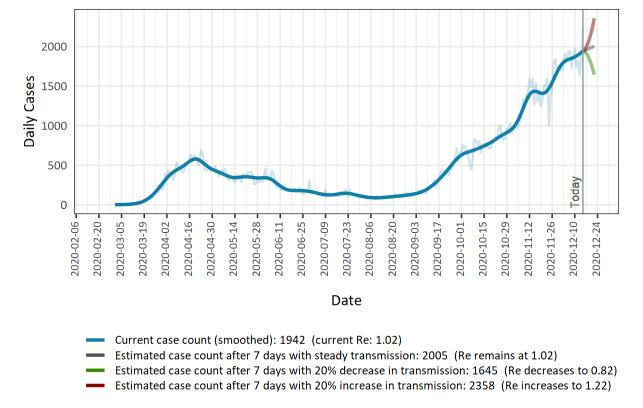

Source: https://www.publichealthontario.ca/-/media/documents/ncov/epi/covid-19-epi-trends-incidence-ontario.pdf?la=en

## Policy recommendation based on current projections

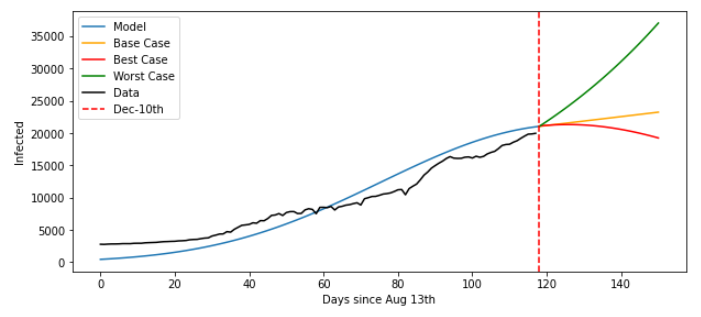

From current projections, we still see potential for a significant rise in infections if the reproduction rate increases. A 20% rise in Re (from 1.1 to 1.3) for the next 30 days will see the number of active infections increase by almost 100%. This can have very serious consequences on the porvince's health care system which is already being stretched by the current case count. </br>

From the data, we see that the first lockdown in March was effective in controlling the spread. The lockdown was imposed early in the infection cycle and the case counts started on a consistent downward trajectory roughly a month after. The second lockdown has not been nearly as effective and was imposed much later in the infection cycle.   

Given that we are moving into the hoiday season, the potential for increase in socialising is high (there by increasing the Re). To prevent this and to try and slowly drive the Re below 1 (best case scenario), we propose implementing a tighter lockdown in the province with clear and consistent messaging against socialising over the holidays. As was the case during the initial days of the first wave   





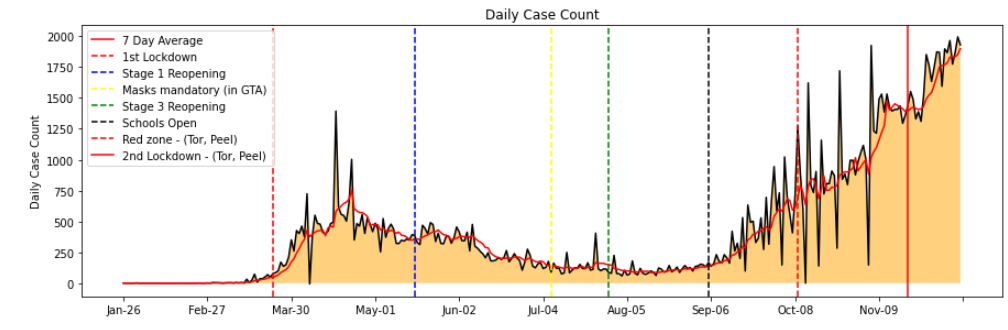

#Part 4 - Additional Modelling

A survey published in the 'Nature Public Health Emergency Collection', found that 68% of Canadians responded positively to the statement '‘If a COVID-19 vaccine is proven safe and effective and is available, I will take it’.  </br>Survey link: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7573523/ </br>



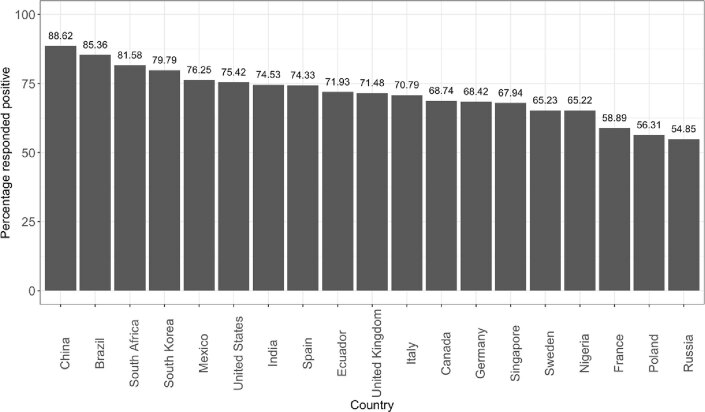

Given the transparent and rigorous vaccine approval process in Canada, we would ideally expect this number to be higher. Also, when widely availabe, rapid uptake of the vaccine will be important in containing the virus. Hence it is important that a large proportion of the population is ready to accept the vaccine. Conversely, now that a vaccine has been approved, people might start being a bit relaxed about precautions, expecting mass inocculation will soon stop the spread. </br>

In such a situation, Public information campaigns can be useful in increasing awarness amongst the population. And a model showing the impact of vaccinations on the spread of the disease might be a good tool to use for such campaigns. Such a model can also inform policy around covid 19 restrictions. For example, companies might be able to better prepare for a regular return to work and governments can start to plan when to ease border restrictions etc.     

## Accounting for vaccinations in SIR model</br>

Vaccinations help stop the spread of the disease by making more people immune to the disease. This means vaccinated people directly jump from the susceptible group to the recovered gorup. Also the number of susciptible people exposed to getting infected reduces by α*t for each t. We'll modify our SIR model as follows to account for vaccinations.

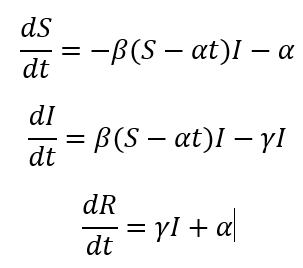

Here, the additional **α** term is the vaccination rate and represents how many people get vaccinated per day. We looked at the vaccine rollout plans published by the ontario and federal governments to estimate **α**. The roll out plans can be found here:</br>

Federal: https://www.canada.ca/content/dam/phac-aspc/documents/services/diseases/2019-novel-coronavirus-infection/canadas-reponse/canadas-covid-19-immunization-plan-en.pdf

Ontario: https://news.ontario.ca/en/release/59607/ontario-begins-rollout-of-covid-19-vaccine

The estimated vaccine rollout schedule is as follows:</br>
*   1.2 million people vaccinated by March: α = 11,500 peope/day  
*   Assuming a 70% uptake of the vaccine - α = 8,050 peope/day 



In [450]:
# Modify SIR to account for vaccinations

# Vacine model with decaying beta 
def dIs_vac(y,t,b_0,omega,alpha):
  S,I,R = y
  gamma = 0.07
  dSdt = -gamma*I*b_0*np.exp(-omega*t)*(S-alpha*(t-118))/(N*gamma) -alpha
  dIdt = gamma*I*(b_0*np.exp(-omega*t)*(S-alpha*(t-118))/(N*gamma)-1)
  dRdt = gamma*I
  return dSdt,dIdt,dRdt

# Vacicne model with constant beta
def dIs_vac_b(y,t,b,alpha):
  S,I,R = y
  gamma = 0.07
  dSdt = -gamma*I*b*(S-alpha*(t-118))/(N*gamma) -alpha
  dIdt = gamma*I*(b*(S-alpha*(t-118))/(N*gamma)-1)
  dRdt = gamma*I
  return dSdt,dIdt,dRdt

In [441]:
# Model initial conditions are the last predicted values from wave 2 modelling
fit_vac_days = np.linspace(118,210,92)
N = 14880000
y0 =  [sol[-1,0],sol[-1,1],sol[-1,2]]

#100% uptake
sol_vac = odeint(dIs_vac,y0,fit_vac_days,args=(SIR_fit[0],SIR_fit[1],11500))
R_0_vac = SIR_fit[0]*np.exp(-SIR_fit[1]*fit_vac_days)/0.07 

#70% uptake
sol_vac_1 = odeint(dIs_vac,y0,fit_vac_days,args=(SIR_fit[0],SIR_fit[1],8050))

b = SIR_fit[0]*np.exp(-SIR_fit[1]*118)
sol_vac_b = odeint(dIs_vac_b,y0,fit_vac_days,args=(b,11500))


In [443]:
fit_best_days = np.linspace(0,210,210)
N = 15000000
y0 = [N-SIR_fit[2],SIR_fit[2],38000]
sol_b = odeint(dIs,y0,fit_best_days,args=(SIR_fit[0],SIR_fit[1]))
R_0_b = SIR_fit[0]*np.exp(-SIR_fit[1]*fit_best_days)/0.07 
sol_best = sol_b[118:,:]

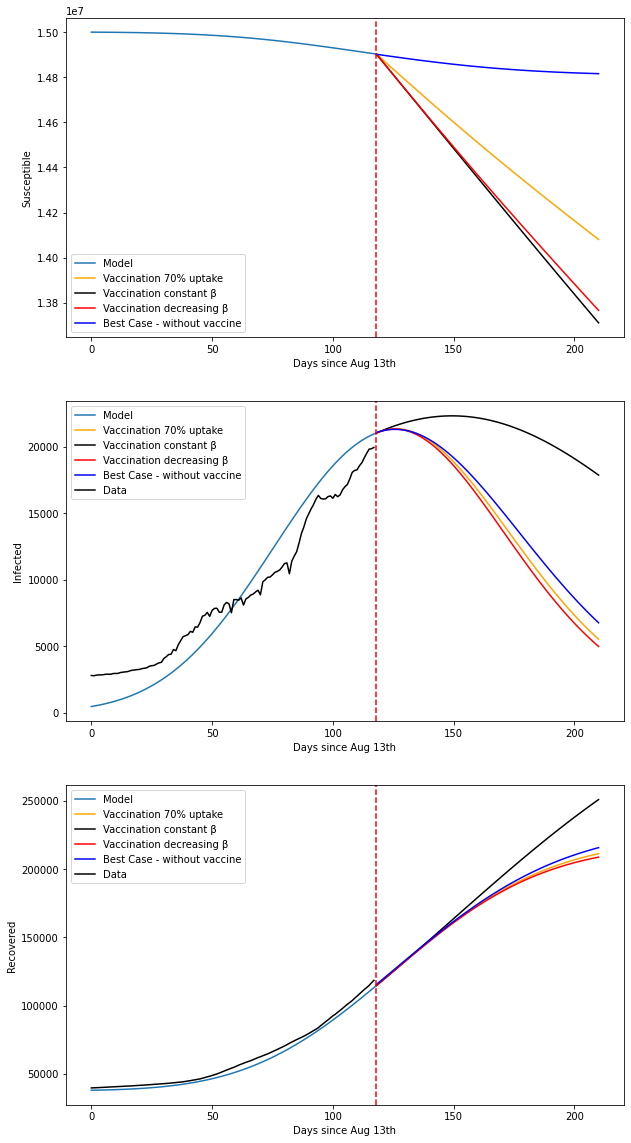

In [449]:
fig,ax = plt.subplots(3,figsize=(10,20))
ax[0].plot(fit_days,sol[:,0],label='Model',c='C0')
ax[0].plot(fit_vac_days,sol_vac_1[:,0],label='Vaccination 70% uptake',c='orange')
ax[0].plot(fit_vac_days,sol_vac_b[:,0],label='Vaccination constant β',c='black')
ax[0].plot(fit_vac_days,sol_vac[:,0],label='Vaccination decreasing β',c='red')
ax[0].plot(fit_vac_days,sol_best[:,0],label='Best Case - without vaccine',c='blue')
ax[0].axvline(x=118,color='r',linestyle = '--')
ax[0].set_ylabel('Susceptible')
ax[0].set_xlabel('Days since Aug 13th')

ax[0].legend()

ax[1].plot(fit_days,sol[:,1],label='Model',c='C0')
ax[1].plot(fit_vac_days,sol_vac_1[:,1],label='Vaccination 70% uptake',c='orange')
ax[1].plot(fit_vac_days,sol_vac_b[:,1],label='Vaccination constant β',c='black')
ax[1].plot(fit_vac_days,sol_vac[:,1],label='Vaccination decreasing β',c='red')
ax[1].plot(fit_vac_days,sol_best[:,1],label='Best Case - without vaccine',c='blue')
ax[1].plot(second_wave_days,ontario_cases['Active'].iloc[202:],label='Data',c='black')
ax[1].axvline(x=118,color='r',linestyle = '--')
ax[1].set_ylabel('Infected')
ax[1].set_xlabel('Days since Aug 13th')
ax[1].legend()

ax[2].plot(fit_days,sol[:,2],label='Model',c='C0')
ax[2].plot(fit_vac_days,sol_vac_1[:,2],label='Vaccination 70% uptake',c='orange')
ax[2].plot(fit_vac_days,sol_vac_b[:,2],label='Vaccination constant β',c='black')
ax[2].plot(fit_vac_days,sol_vac[:,2],label='Vaccination decreasing β',c='red')
ax[2].plot(fit_vac_days,sol_best[:,2],label='Best Case - without vaccine',c='blue')
ax[2].plot(second_wave_days,ontario_cases['Removed'].iloc[202:],label='Data',c='black')
ax[2].axvline(x=118,color='r',linestyle = '--')
ax[2].set_ylabel('Recovered')
ax[2].set_xlabel('Days since Aug 13th')
ax[2].legend()



## Policy Recommendations based on vaccine modelling

From the above curves, we see that the vaccination drive will contribute towards reducing the spread. But at the proposed vaccination rate over the next 3 months, the effect won't be significant. It is therefore vital that we maintain, or tighten current levels of restriction over the next few months. 

From the model we see that **β** (transmission rate) has a larger influence on the infection rate than **-αt** (vaccination rate) in the first few months. This can be seen by comparing the **constant β** vs **decreasing β** scenarios.   Therefore it might be ill advised to start easing restriction too early by banking on the effect of the vaccine. Lowering **β** should still be the preferred approach and hence up holding current restrictions and social distancing measures in the near term should be the preferred strategy for controlling the spread.   